In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging

from tqdm.auto import tqdm
import jax
from jax import random
import numpy as np
import optax
import wandb

from src.models.vae import VAE, make_VAE_loss, make_VAE_eval
from src.data import get_image_dataset, NumpyLoader
from src.utils.plotting import plot_img_array
from src.utils.flax import TrainState

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'train_vae.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb.init(
    project='learning-invariances',
    entity='invariance-learners',
    config={
        'learning_rate': 3e-3,
        'epochs': 2,
        'batch_size': 512,
        'latent_size': 50,
        'likelihood': 'diag-normal',
        'posterior': 'diag-normal',
        'learn_prior': False,
        'convolutional': False,
        'encoder_hidden_dims': [128, 256, 512],
        'decoder_hidden_dims': [128, 256, 512],
        'act_fun': 'gelu', 
        'model': 'VAE',
    },
    # notes='',
    # mode='disabled',
)
config = wandb.config 

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


In [4]:
# Fix for annoying "WARNING:root:The use of `check_types` is deprecated and does not have any effect."
# error message produced by tfp.
logger = logging.getLogger('root')

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return 'check_types' not in record.getMessage()

logger.addFilter(CheckTypesFilter())

In [5]:
rng = random.PRNGKey(0)

In [6]:
train_dataset, test_dataset = get_image_dataset('MNIST', valid_percent=0., flatten_img=True)
train_loader = NumpyLoader(train_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, 10_000)

In [7]:
model = VAE(
    784, config.latent_size,
    enc_hidden_dims=config.encoder_hidden_dims,
    dec_hidden_dims=config.decoder_hidden_dims,
)

init_rng, rng = random.split(rng)
init_data = train_dataset[0][0]
variables = model.init(init_rng, init_data, rng)
model_state, params = variables.pop('params')
del variables

state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optax.adamw(config.learning_rate),
    model_state=model_state
)

  0%|          | 0/2 [00:00<?, ?it/s]

epoch:   0 - train loss:   0.0235, test_loss:   0.0212


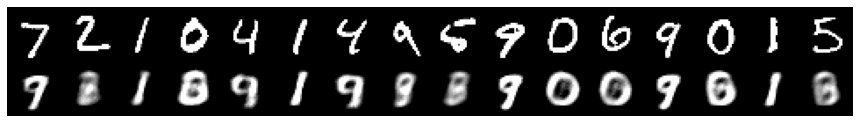

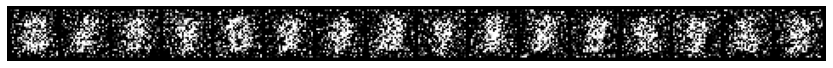

epoch:   1 - train loss:   0.0190, test_loss:   0.0170


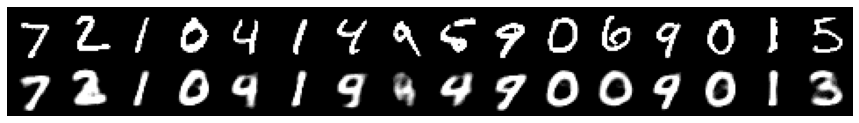

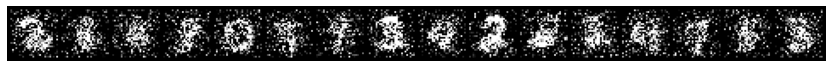

In [8]:
z_rng, rng = random.split(rng)
zs = random.normal(z_rng, (16, config.latent_size))

@jax.jit
def train_step(state, x_batch, rng):
    loss_fn = make_VAE_loss(model, x_batch, train=True)
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  
    (loss, (model_state,)), grads = grad_fn(state.params, state.model_state, rng)

    return state.apply_gradients(grads=grads, model_state=model_state), loss


test_x, _ = next(iter(test_loader))
eval_fn = make_VAE_eval(model, test_x, zs)


train_losses = []
test_losses = []
for epoch in tqdm(range(config.epochs)):
    batch_losses = []

    for (x_batch, _) in train_loader:
        rng, batch_rng = random.split(rng)
        state, loss = train_step(state, x_batch, batch_rng)
        batch_losses.append(loss)

    train_losses.append(np.mean(batch_losses))

    rng, eval_rng = random.split(rng)
    test_metrics, recon_comparison, sampled_images = eval_fn(
        state.params, state.model_state, eval_rng
    )
    test_losses.append(-test_metrics['elbo'])

    print(f'epoch: {epoch:3} - train loss: {train_losses[-1]:8.4f}, test_loss: {test_losses[-1]:8.4f}')
    recon_plot = plot_img_array(recon_comparison)
    samples_plot = plot_img_array(sampled_images)

    metrics = {
        'epoch': epoch,
        'train/train_loss': train_losses[-1],
        'test/test_loss': test_losses[-1],
        'reconstructions': recon_plot,
        'prior_samples': samples_plot,
    }
    wandb.log({**metrics})

In [9]:
wandb.finish()

epoch,▁█
test/test_loss,█▁
train/train_loss,█▁
epoch,1
test/test_loss,0.01704
train/train_loss,0.01901
